In [1]:
import os
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

### Initialise the environment

In [2]:
p1 = 0.7 # reward proba for arm 1
p2 = 0.5 # reward proba for arm 2

arms = [p1, p2]

### Initialise the agent

In [11]:
def policy(q_values, temp=None):

    if temp:
        t = temp
    else:
        t = 1
    return np.exp(q_values*t)/np.sum(np.exp(q_values*t))

def belief_update(M_curr, arm, rew):

    M_next = M_curr.copy()
    if rew == 1:
        M_next[arm, 0] += 1
    else:
        M_next[arm, 1] += 1
    return M_next

# initial belief state
M = np.array([
    [1, 1],
    [1, 1]
], dtype=int)

### Run the model-free agent

In [12]:
np.random.seed(1234)

num_episodes = 10
for ep in range(num_episodes):
    Q      = [M[0, 0]/(M[0, 0] + M[0, 1]), M[1, 0]/(M[1, 0] + M[1, 1])]
    probas = policy(Q, temp=None)
    a      = np.random.choice([0, 1], p=probas)
    r      = np.random.choice([0, 1], p=(1-arms[a], arms[a]))
    M      = belief_update(M, a, r)

### Plot the resulting belief

Text(0.5, 1.0, '$\\mathbb{E}[p\\mid b]$')

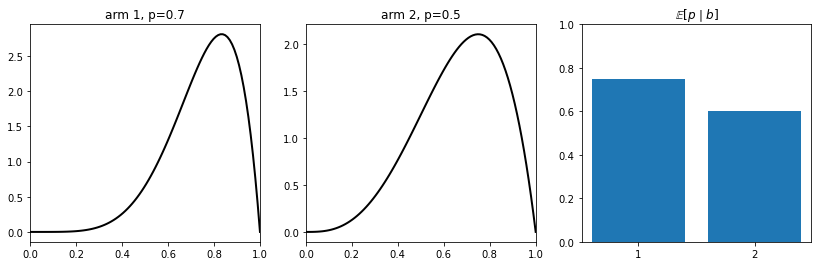

In [13]:
plt.figure(figsize=(14, 4))

x = np.linspace(0, 1, 100)
plt.subplot(1, 3, 1)
a, b = M[0, 0], M[0, 1]
rv = beta(a, b)
plt.plot(x, rv.pdf(x), 'k-', lw=2)
plt.xlim(0,1)
plt.title('arm 1, p=%.1f'%arms[0])
plt.subplot(1, 3, 2)
a, b = M[1, 0], M[1, 1]
rv = beta(a, b)
plt.plot(x, rv.pdf(x), 'k-', lw=2)
plt.xlim(0,1)
plt.title('arm 2, p=%.1f'%arms[1])
plt.subplot(1, 3, 3)
plt.bar([1, 2], Q)
plt.xticks([1, 2], [1, 2])
plt.ylim(0,1)
plt.title(r'$\mathbb{E}[p\mid b]$')

In [14]:
M

array([[6, 2],
       [4, 2]])

In [17]:
gamma   = 0.9
gittins = np.genfromtxt('../gittins100.csv', delimiter=',')
gittins = gittins[1:, 1:] # remove (0, .) and (., 0) priors

### Construct belief tree

In [16]:
def get_belief_tree(h, b):

    # initialise the hyperstate tree
    tree = {hi:{} for hi in range(h)}
    
    tree[0][(0, 0)] = b
    tree[0][(1, 0)] = b

    for hi in range(1, h):
        c  = 0
        for k, v in tree[hi-1].items():
            
            prev_a = k[0]
            prev_c = k[-1]
            
            for r in [0, 1]:
                b1 = belief_update(v, prev_a, r)
                
                for a1 in range(2):
                    
                    tree[hi][(a1, prev_c, c)] = b1
                    c += 1
    return tree

### Replay in belief tree

We want to prioritise updates in this belief tree. The prioritisation scheme is the following:

$$
\begin{align*}
v(b')-v(b)=&\sum_a\big[ ( \pi(a\mid b')-\pi(a\mid b) )q(b', a)\big]\\
&+\mathbb{E}_{\pi(a\mid b)}\big[r(b',a) - r(b,a)\big]\\ 
&+\mathbb{E}_{\pi(a\mid b)}\big[\gamma \sum_{b''}p(b''\mid b', a)v(b'') - \gamma \sum_{b'}p(b'\mid b, a)v(b') \big]
\end{align*}
$$

where the policy $\pi(a\mid b)$ is determined by the Gittins index associated with belief $b$, $q(b', a)$ is the Gittins index, and $v(b')=\mathbb{E}_{\pi(a\mid b')}\big[q(b',a)\big]$

For the moment, we will only consider single-step updates from children to their parents

In [22]:
def evb(b, b_prime):

    q = np.array([gittins[b[0, 0], b[0, 1]], gittins[b[1, 0], b[1, 1]]])
    q_prime = np.array([gittins[b_prime[0, 0], b_prime[0, 1]], gittins[b_prime[1, 0], b_prime[1, 1]]])

    probs = policy(q)
    probs_prime = policy(q_prime)

    gain = np.dot(probs_prime - probs, q_prime)

    tmp_rew = np.array([b[0, 0]/np.sum(b[0, :]), b[1, 0]/np.sum(b[1, :])])
    tmp_rew_prime = np.array([b_prime[0, 0]/np.sum(b_prime[0, :]), b_prime[1, 0]/np.sum(b_prime[1, :])])

    rew = np.dot(probs, (tmp_rew_prime - tmp_rew))

    b_prime00 = belief_update(b, 0, 0)
    b_prime01 = belief_update(b, 0, 1)
    b_prime10 = belief_update(b, 1, 0)
    b_prime11 = belief_update(b, 1, 1)

    q_prime00 = np.array([gittins[b_prime00[0, 0], b_prime00[0, 1]], gittins[b_prime00[1, 0], b_prime00[1, 1]]])
    q_prime01 = np.array([gittins[b_prime01[0, 0], b_prime01[0, 1]], gittins[b_prime01[1, 0], b_prime01[1, 1]]])
    q_prime10 = np.array([gittins[b_prime10[0, 0], b_prime10[0, 1]], gittins[b_prime10[1, 0], b_prime10[1, 1]]])
    q_prime11 = np.array([gittins[b_prime11[0, 0], b_prime11[0, 1]], gittins[b_prime11[1, 0], b_prime11[1, 1]]])

    b_prime_prime00 = belief_update(b_prime, 0, 0)
    b_prime_prime01 = belief_update(b_prime, 0, 1)
    b_prime_prime10 = belief_update(b_prime, 1, 0)
    b_prime_prime11 = belief_update(b_prime, 1, 1)

    q_prime_prime00 = np.array([gittins[b_prime_prime00[0, 0], b_prime_prime00[0, 1]], gittins[b_prime_prime00[1, 0], b_prime_prime00[1, 1]]])
    q_prime_prime01 = np.array([gittins[b_prime_prime01[0, 0], b_prime_prime01[0, 1]], gittins[b_prime_prime01[1, 0], b_prime_prime01[1, 1]]])
    q_prime_prime10 = np.array([gittins[b_prime_prime10[0, 0], b_prime_prime10[0, 1]], gittins[b_prime_prime10[1, 0], b_prime_prime10[1, 1]]])
    q_prime_prime11 = np.array([gittins[b_prime_prime11[0, 0], b_prime_prime11[0, 1]], gittins[b_prime_prime11[1, 0], b_prime_prime11[1, 1]]])

    v_prime0 = (b[0, 0]/np.sum(b[0, :]))*np.dot(policy(q_prime00), q_prime00) + (b[0, 1]/np.sum(b[0, :]))*np.dot(policy(q_prime01), q_prime01)
    v_prime1 = (b[1, 0]/np.sum(b[1, :]))*np.dot(policy(q_prime10), q_prime10) + (b[1, 1]/np.sum(b[1, :]))*np.dot(policy(q_prime11), q_prime11)
    
    v_prime_prime0 = (b_prime[0, 0]/np.sum(b_prime[0, :]))*np.dot(policy(q_prime_prime00), q_prime_prime00) + (b_prime[0, 1]/np.sum(b_prime[0, :]))*np.dot(policy(q_prime_prime01), q_prime_prime01)
    v_prime_prime1 = (b_prime[1, 0]/np.sum(b_prime[1, :]))*np.dot(policy(q_prime_prime10), q_prime_prime10) + (b_prime[1, 1]/np.sum(b_prime[1, :]))*np.dot(policy(q_prime_prime11), q_prime_prime11)

    nxt = gamma*(np.dot(probs, np.array([v_prime0, v_prime1])) + np.dot(probs, np.array([v_prime_prime0, v_prime_prime1]))) 

    return gain + rew + nxt

In [23]:
h    = 6
tree = get_belief_tree(h, M)

In [24]:
evb_tree = {hi:{} for hi in range(h)}
for hi in reversed(range(h-1)):
    for k, v in tree[hi].items():
        c = k[-1]
        a = k[0]
        for k1, v1 in tree[hi+1].items():
            if k1[-2] == c:
                evb_tree[hi][(a, c)] = evb(v, v1)

In [34]:
evb_tree[1]

{(0, 0): 0.9085951219721602,
 (1, 1): 0.9058704225288737,
 (0, 2): 0.8320280705417495,
 (1, 3): 0.8279303814007768,
 (0, 4): 0.915489611067945,
 (1, 5): 0.9140229929129368,
 (0, 6): 0.8058010835175641,
 (1, 7): 0.8044251732820278}